In [1]:
import torch
from basic_unet import UNet
from testnet import TestnetDataset
from plot_utils import plot_image_row
from torchvision import transforms
from pathlib import Path
import hdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1)
state_dict = torch.load('models/2_testnet_0490.pth')
model.load_state_dict(state_dict)
model = model.to(device)
transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
])
dataset = TestnetDataset(Path('testnet'), transform)

In [3]:
explainer = hdm.HausdorffDistanceMasks(240, 240)
explainer.generate_masks(circle_size=30, offset=5, normalize=False)

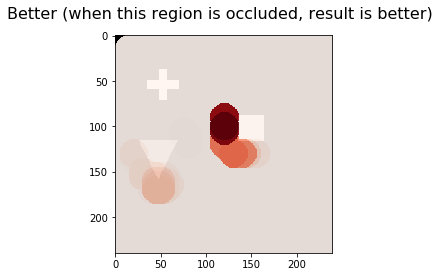

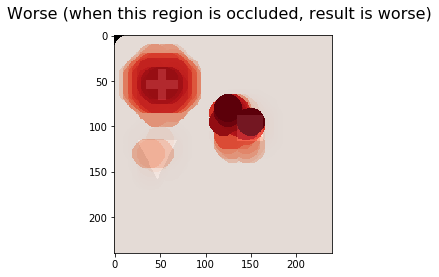

In [4]:
sample = dataset.get_sample('1')
segment = sample['segment']
image = sample['input']
result = explainer.explain(model, image, segment, device)

raw = result.circle_map(hdm.RAW)
absolute = result.circle_map(hdm.ABSOLUTE)
better = result.circle_map(hdm.BETTER_ONLY)
worse = result.circle_map(hdm.WORSE_ONLY)

plot_image_row(
    image,
    title='Better (when this region is occluded, result is better)',
    color_map='gray',
    overlay=better,
    overlay_alpha=0.9,
)
plot_image_row(
    image,
    title='Worse (when this region is occluded, result is worse)',
    color_map='gray',
    overlay=worse,
    overlay_alpha=0.9,
)

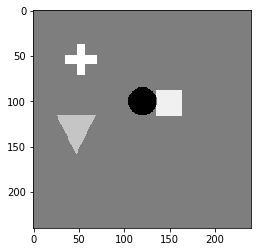

In [5]:
mask_x = 17
mask_y = 21
plt.imshow(image[0], cmap='gray')
plt.imshow(explainer.masks[mask_x][mask_y], cmap='gray', alpha=0.5)
plt.show()

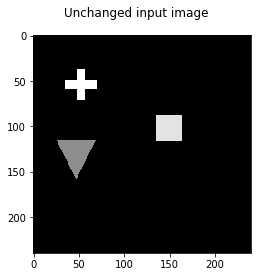

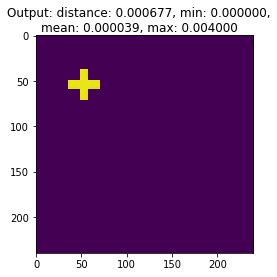

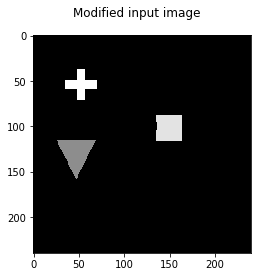

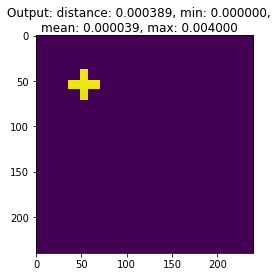

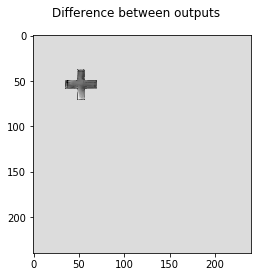

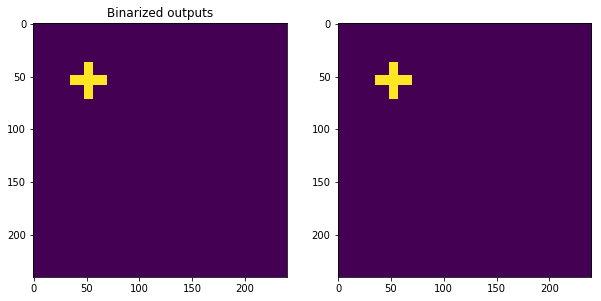

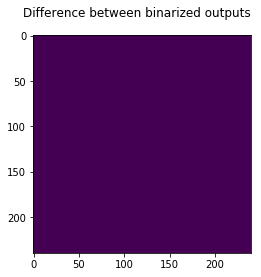

In [6]:
plt.imshow(image[0], cmap='gray')
plt.suptitle('Unchanged input image')
plt.show()

output = model(image.to(device).unsqueeze(0)).detach().cpu().squeeze()
distance = explainer.distance(model, image, segment, device)
plt.suptitle(f'Output: distance: {distance:.6f}, min: {output.min():.6f},\n'
             f'mean: {output.mean():.6f}, max: {output.max():.6f}')
plt.imshow(output)
plt.show()

masked_image = explainer.apply_mask(explainer.masks[mask_x][mask_y], image[0])
distance = explainer.distance(model, masked_image.unsqueeze(0), segment, device)
plt.suptitle(f'Modified input image')
plt.imshow(masked_image, cmap='gray')
plt.show()

output_masked = model(masked_image.unsqueeze(0).to(device).unsqueeze(0)).detach().cpu().squeeze()
plt.suptitle(f'Output: distance: {distance:.6f}, min: {output.min():.6f},\n'
             f'mean: {output.mean():.6f}, max: {output.max():.6f}')
plt.imshow(output_masked)
plt.show()

plt.suptitle('Difference between outputs')
plt.imshow(output - output_masked, cmap='gray')
plt.show()

output = output > 0.0005
output_masked = output_masked > 0.0005
plot_image_row([output, output_masked], labels=['Binarized outputs', ''])

plt.suptitle('Difference between binarized outputs')
plt.imshow(output - output_masked)
plt.show()